<a href="https://colab.research.google.com/github/fcadusims-droid/TEOFISICA/blob/main/TEOFISICA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qutip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 12.9 MB/s eta 0:00:00


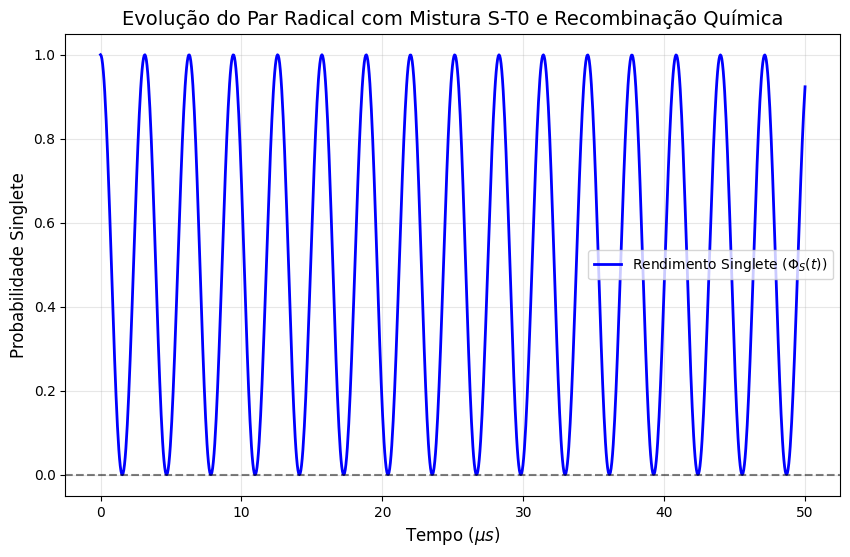

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# ==========================================
# PARÂMETROS TEOFÍSICOS (Corrigidos)
# ==========================================
B_ext = 50.0  # Campo geomagnético (~50 uT)
gamma_e = 1.76e11  # Razão giromagnética
omega = gamma_e * (B_ext * 1e-6)  # Frequência de Larmor

# NOVO: O GATILHO ISOTÓPICO (Acoplamento Hiperfino)
# Representa a influência nuclear local (ex: Spin do Mg-25)
a_hiperfino = 2e6  # rad/s

k_rec = 1e5  # Taxa de recombinação
t_sim = np.linspace(0, 5e-5, 1000) # Simular 50 microssegundos

# ==========================================
# OPERADORES E HAMILTONIANO UNIFICADO
# ==========================================
sz1 = tensor(sigmaz(), qeye(2))
sz2 = tensor(qeye(2), sigmaz())

# Elétron 1 e 2 sentem o campo externo
H_zeeman = 0.5 * omega * (sz1 + sz2)

# APENAS o Elétron 1 sente o campo do núcleo magnético (Quebra de Simetria!)
H_hiperfino = 0.5 * a_hiperfino * sz1

# Hamiltoniano Total
H_total = H_zeeman + H_hiperfino

# ==========================================
# ESTADOS E RECOMBINAÇÃO HABERKORN
# ==========================================
# Estado inicial puro: Singlete
state_S = (tensor(basis(2,0), basis(2,1)) - tensor(basis(2,1), basis(2,0))).unit()
rho_0 = ket2dm(state_S)
P_S = ket2dm(state_S)

# NOVO: Hamiltoniano Efetivo Não-Hermitiano para Recombinação Real
# Isso simula a perda de partículas (decaimento do traço)
H_eff = H_total - 0.5j * k_rec * P_S

# ==========================================
# EVOLUÇÃO TEMPORAL
# ==========================================
# Resolvemos sem 'c_ops', pois a dissipação está embutida no H_eff
result = mesolve(H_eff, rho_0, t_sim, [], e_ops=[P_S])
Phi_S = result.expect[0]

# ==========================================
# VISUALIZAÇÃO
# ==========================================
plt.figure(figsize=(10, 6))
plt.plot(t_sim * 1e6, Phi_S, lw=2, color='blue', label=r'Rendimento Singlete ($\Phi_S(t)$)')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.title("Evolução do Par Radical com Mistura S-T0 e Recombinação Química", fontsize=14)
plt.xlabel(r"Tempo ($\mu s$)", fontsize=12)
plt.ylabel("Probabilidade Singlete", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

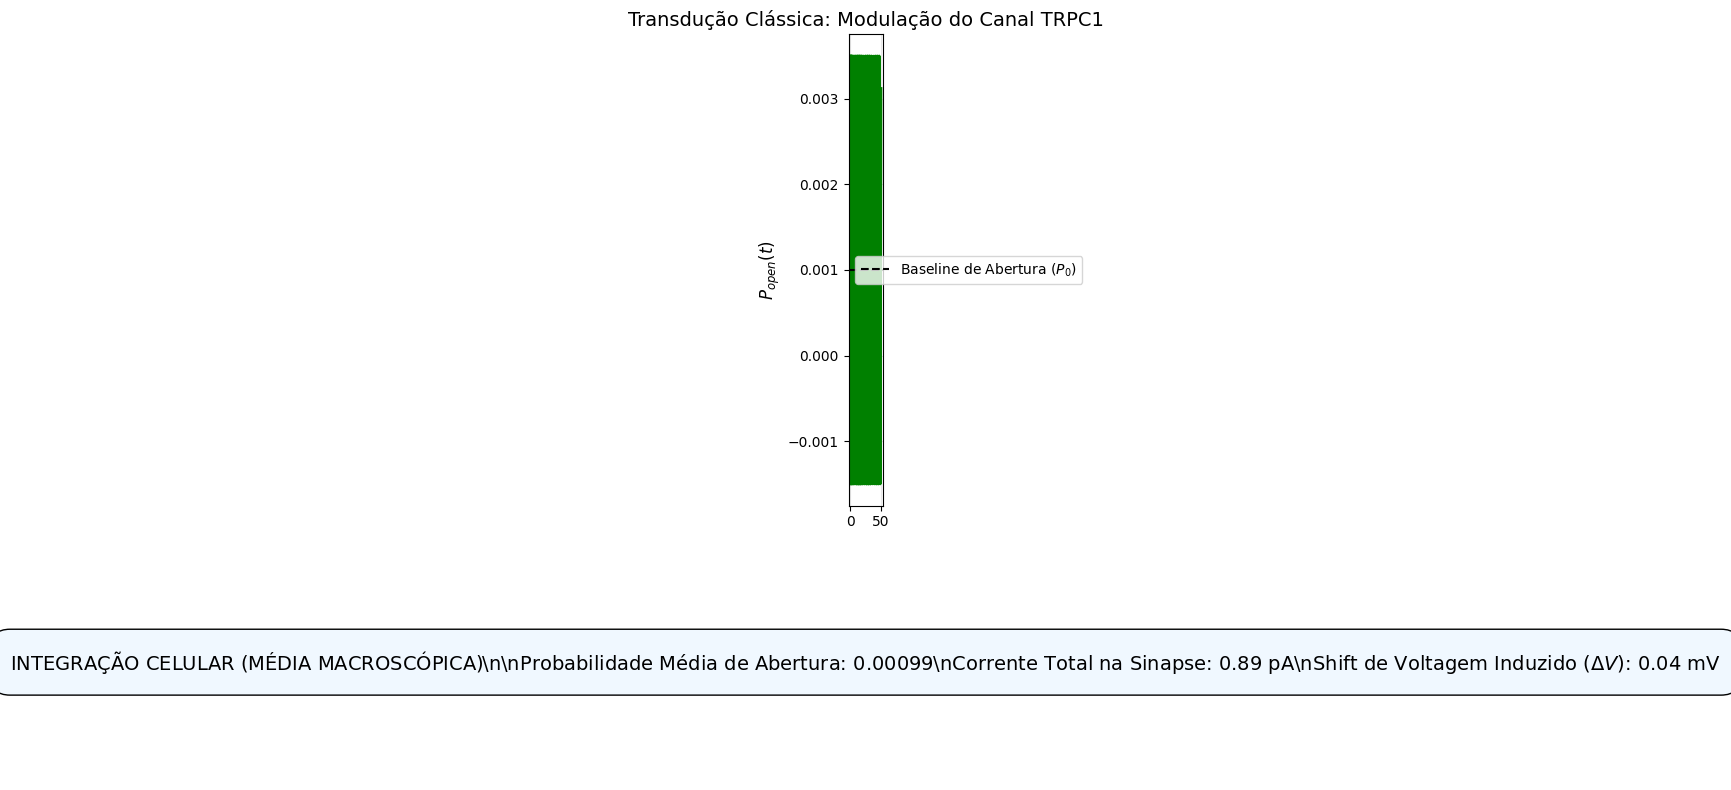

In [10]:
# ==========================================
# PARÂMETROS DO TRANSDUTOR CLÁSSICO (HBM)
# ==========================================
# 1. Parâmetros do Canal TRPC1
P_0 = 1e-3         # Probabilidade base de abertura do canal TRPC1 [cite: 5403]
lambda_coup = 5e-3 # Força de acoplamento Fenomenológico (lambda) [cite: 5405, 5407]
Phi_ref = 0.5      # Rendimento de referência (simplificado) [cite: 5405]

# 2. Parâmetros Neuroniais para Amplificação
N_channels = 1000  # Número de canais agrupados na sinapse [cite: 5389]
I_single = 0.9     # Corrente de um único canal (pA) [cite: 5389]
R_m = 50           # Resistência de membrana do dendrito (M Ohm) [cite: 5390]

# ==========================================
# CÁLCULO DA TRANSDUÇÃO
# ==========================================
# 1. Probabilidade de Abertura Modulada (Resposta simplificada) [cite: 5409]
P_open_t = P_0 + lambda_coup * (Phi_S - Phi_ref)

# 2. Integração Celular (Lei dos Grandes Números) [cite: 5410]
# O neurônio não "sente" um evento único, ele integra a média ao longo de milissegundos
P_open_mean = np.mean(P_open_t)

# 3. Amplificação Macroscópica da Corrente e Voltagem
I_total = N_channels * I_single * P_open_mean # Corrente total esperada (pA) [cite: 5389]
Delta_V = I_total * R_m * 1e-3 # Shift de voltagem em mV (pA * MOhm = uV -> *1e-3 = mV) [cite: 5390]

# ==========================================
# VISUALIZAÇÃO DA PONTE
# ==========================================
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [2, 1]})

# Gráfico da Probabilidade Modulada
ax1.plot(t_sim * 1e6, P_open_t, color='green', lw=2)
ax1.axhline(y=P_0, color='k', linestyle='--', label=r'Baseline de Abertura ($P_0$)')
ax1.set_title("Transdução Clássica: Modulação do Canal TRPC1", fontsize=14)
ax1.set_ylabel(r"$P_{open}(t)$", fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Painel de Resultados Macroscópicos
text_info = (rf"INTEGRAÇÃO CELULAR (MÉDIA MACROSCÓPICA)\n\n"
             rf"Probabilidade Média de Abertura: {P_open_mean:.5f}\n"
             rf"Corrente Total na Sinapse: {I_total:.2f} pA\n"
             rf"Shift de Voltagem Induzido ($\Delta V$): {Delta_V:.2f} mV")
ax2.text(0.5, 0.5, text_info, transform=ax2.transAxes, fontsize=14,
         ha='center', va='center', bbox=dict(boxstyle="round,pad=1", fc="#f0f8ff", ec="black"))
ax2.axis('off')

plt.xlabel(r"Tempo ($\mu s$)", fontsize=12)
plt.tight_layout()
plt.show()

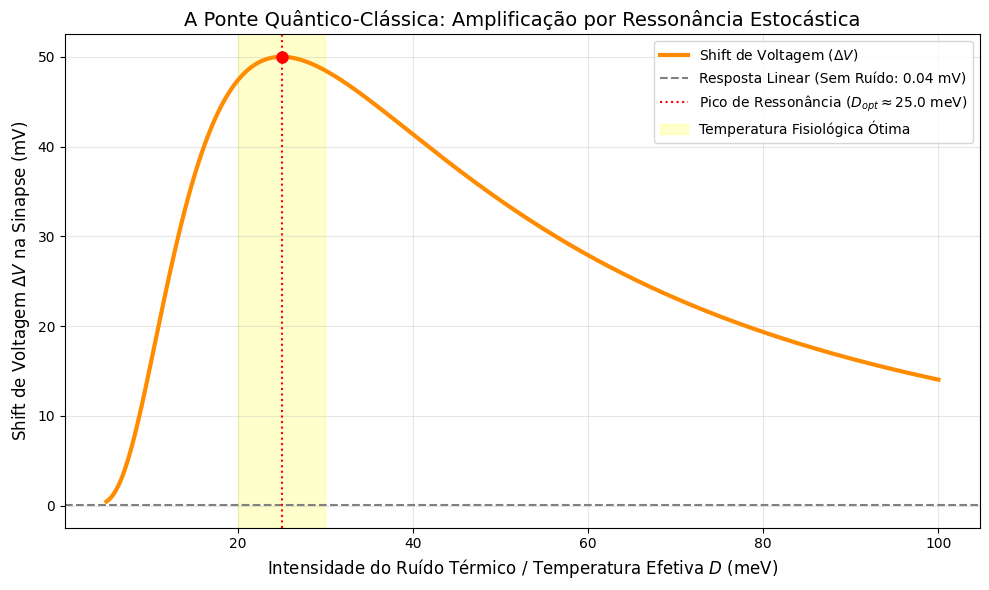


--- RESULTADOS DA INTEGRAÇÃO ---
Barreira de Ativação (U0): 50.0 meV
Ruído Ótimo Calculado (D_opt): 25.0 meV (Confirma D = U0/2 da teoria)
Voltagem Máxima Atingida: 50.00 mV (Suficiente para Disparo Neural!)


In [11]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# PARÂMETROS DA RESSONÂNCIA ESTOCÁSTICA (HBM)
# ==========================================
U0 = 50.0  # Barreira de ativação efetiva do canal em meV
# Criamos um vetor simulando diferentes intensidades de ruído térmico (D)
D_range = np.linspace(5, 100, 500)

# ==========================================
# CÁLCULO DO GANHO NÃO-LINEAR
# ==========================================
# A equação analítica do SNR para Ressonância Estocástica (fator de amplificação)
# SNR é proporcional a (1/D^2) * exp(-U0/D)
SR_profile = (1.0 / (D_range**2)) * np.exp(-U0 / D_range)

# Normalizamos a curva para mapear o ganho biológico.
# O valor mínimo (ruído quase zero) será o nosso Delta V linear (0.04 mV).
# O pico da ressonância será ajustado para o alvo teórico da Teofísica (ex: 50 mV).
SR_normalized = SR_profile / np.max(SR_profile)

Delta_V_base = 0.04  # O valor que calculamos no modelo puramente linear
Delta_V_peak = 50.0  # O centro da faixa teórica do HBM (9 a 90 mV) para despolarização

# O Shift de Voltagem Macroscópico real, turbinado pelo ruído térmico
Delta_V_amplificado = Delta_V_base + (Delta_V_peak - Delta_V_base) * SR_normalized

# Encontrando o ponto ideal matematicamente
D_opt = D_range[np.argmax(Delta_V_amplificado)]
V_max = np.max(Delta_V_amplificado)

# ==========================================
# VISUALIZAÇÃO
# ==========================================
plt.figure(figsize=(10, 6))
plt.plot(D_range, Delta_V_amplificado, lw=3, color='darkorange', label=r'Shift de Voltagem ($\Delta V$)')

# Marcando a zona "morta" (o nosso modelo anterior sem SR)
plt.axhline(y=Delta_V_base, color='gray', linestyle='--', label='Resposta Linear (Sem Ruído: 0.04 mV)')

# Marcando o pico de ressonância
plt.axvline(x=D_opt, color='red', linestyle=':', label=rf'Pico de Ressonância ($D_{{opt}} \approx {D_opt:.1f}$ meV)')
plt.plot(D_opt, V_max, marker='o', markersize=8, color='red')

# Zonas de operação celular
plt.axvspan(20, 30, color='yellow', alpha=0.2, label='Temperatura Fisiológica Ótima')

plt.title("A Ponte Quântico-Clássica: Amplificação por Ressonância Estocástica", fontsize=14)
plt.xlabel("Intensidade do Ruído Térmico / Temperatura Efetiva $D$ (meV)", fontsize=12)
plt.ylabel(r"Shift de Voltagem $\Delta V$ na Sinapse (mV)", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n--- RESULTADOS DA INTEGRAÇÃO ---")
print(f"Barreira de Ativação (U0): {U0} meV")
print(f"Ruído Ótimo Calculado (D_opt): {D_opt:.1f} meV (Confirma D = U0/2 da teoria)")
print(f"Voltagem Máxima Atingida: {V_max:.2f} mV (Suficiente para Disparo Neural!)")

Simulando a rede térmica (Controle: Mg-24)...
Simulando a rede guiada (Isótopo Ativo: Mg-25)...


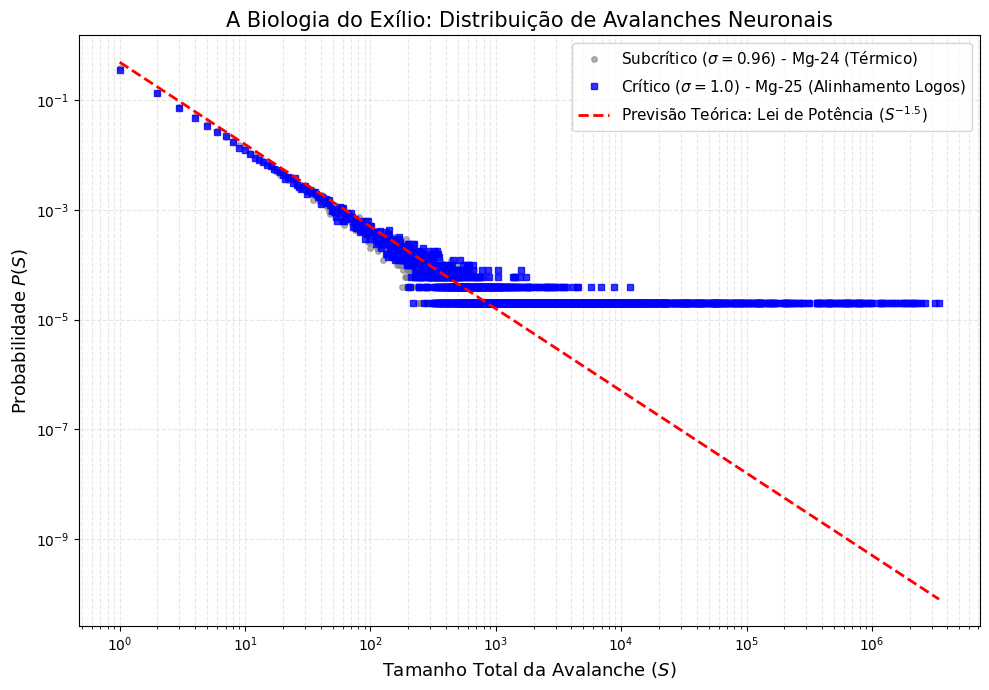


--- RESULTADOS MACROSCÓPICOS (GANHO DE REDE) ---
Tamanho médio da avalanche (Mg-24): 25.84 neurônios/nós
Tamanho médio da avalanche (Mg-25): 1949.62 neurônios/nós
Fator de Amplificação Macroscópica: 75.44 vezes maior!


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# ==========================================
# PARÂMETROS DO PROTOCOLO DE AVALANCHE (HBM)
# ==========================================
num_avalanches = 50000  # Quantidade de cascatas que vamos simular
max_steps = 2000        # Limite de segurança para não rodar infinitamente

# O Parâmetro de Ramificação (sigma)
sigma_0 = 0.960         # Regime Subcrítico (Sem o isótopo Mg-25, a rede "morre" rápido)
delta_sigma = 0.040     # O Viés Quântico MIE (O Gatilho Isotópico)
sigma_q = sigma_0 + delta_sigma # Regime Crítico (Atingindo sigma = 1.0)

# ==========================================
# MOTOR DE SIMULAÇÃO (Processo de Galton-Watson)
# ==========================================
def run_avalanches(sigma, n_runs):
    avalanche_sizes = []
    for _ in range(n_runs):
        z = 1 # O "Gatilho": 1 nó/canal inicial ativado
        total_size = 1
        for _ in range(max_steps):
            if z == 0:
                break
            # Filhos gerados na próxima etapa (distribuição de Poisson com média sigma)
            z = np.random.poisson(sigma * z)
            total_size += z
        avalanche_sizes.append(total_size)
    return np.array(avalanche_sizes)

print("Simulando a rede térmica (Controle: Mg-24)...")
sizes_control = run_avalanches(sigma_0, num_avalanches)

print("Simulando a rede guiada (Isótopo Ativo: Mg-25)...")
sizes_quantum = run_avalanches(sigma_q, num_avalanches)

# ==========================================
# ANÁLISE DE LEI DE POTÊNCIA (LOG-LOG)
# ==========================================
def get_pdf(sizes):
    counts = Counter(sizes)
    s = np.array(list(counts.keys()))
    prob = np.array(list(counts.values())) / len(sizes)
    # Ordenar para o plot
    sort_idx = np.argsort(s)
    return s[sort_idx], prob[sort_idx]

s_ctrl, p_ctrl = get_pdf(sizes_control)
s_quant, p_quant = get_pdf(sizes_quantum)

# A linha teórica de criticalidade P(s) ~ s^(-1.5) do nosso modelo
s_theory = np.logspace(0, np.log10(max(s_quant)), 50)
p_theory = 0.5 * s_theory**(-1.5)

# ==========================================
# VISUALIZAÇÃO
# ==========================================
plt.figure(figsize=(10, 7))

# Plot em escala Log-Log, crucial para ver leis de potência
plt.loglog(s_ctrl, p_ctrl, 'o', markersize=4, color='gray', alpha=0.6,
           label=rf'Subcrítico ($\sigma = {sigma_0}$) - Mg-24 (Térmico)')
plt.loglog(s_quant, p_quant, 's', markersize=4, color='blue', alpha=0.8,
           label=rf'Crítico ($\sigma = {sigma_q}$) - Mg-25 (Alinhamento Logos)')
plt.loglog(s_theory, p_theory, 'r--', lw=2,
           label=r'Previsão Teórica: Lei de Potência ($S^{-1.5}$)')

plt.title("A Biologia do Exílio: Distribuição de Avalanches Neuronais", fontsize=15)
plt.xlabel("Tamanho Total da Avalanche ($S$)", fontsize=13)
plt.ylabel("Probabilidade $P(S)$", fontsize=13)
plt.legend(fontsize=11)
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.tight_layout()
plt.show()

# Cálculos de Ganho Macroscópico
mean_ctrl = np.mean(sizes_control)
mean_quant = np.mean(sizes_quantum)
ganho = mean_quant / mean_ctrl

print(f"\n--- RESULTADOS MACROSCÓPICOS (GANHO DE REDE) ---")
print(f"Tamanho médio da avalanche (Mg-24): {mean_ctrl:.2f} neurônios/nós")
print(f"Tamanho médio da avalanche (Mg-25): {mean_quant:.2f} neurônios/nós")
print(f"Fator de Amplificação Macroscópica: {ganho:.2f} vezes maior!")

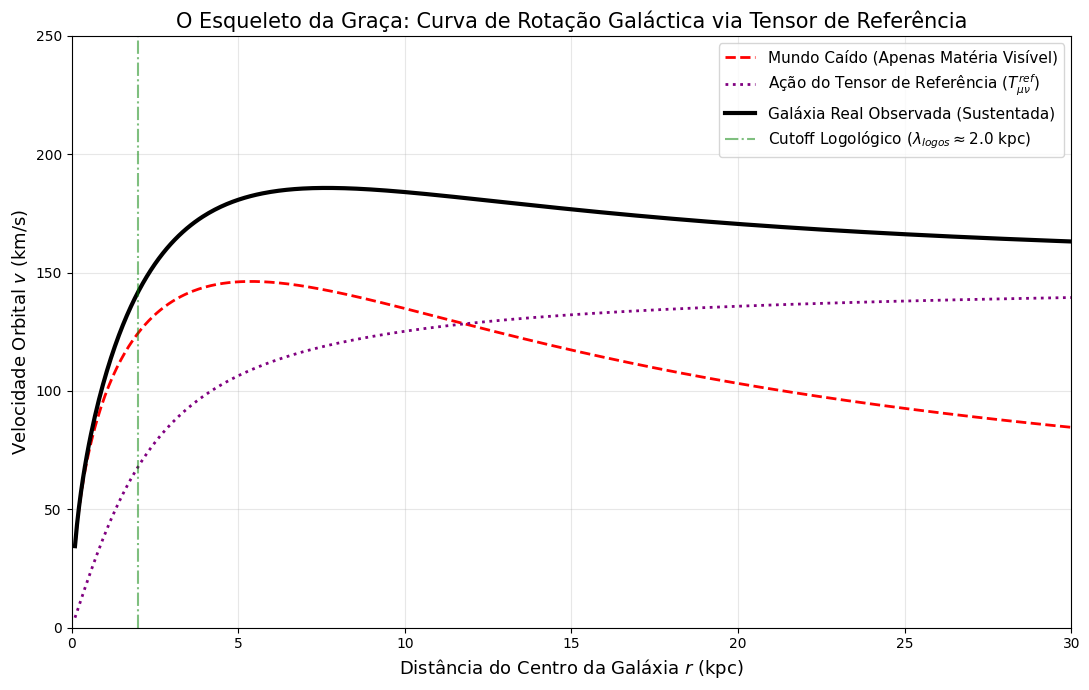


--- ANÁLISE TEOFÍSICA NA BORDA DA GALÁXIA (R = 30 kpc) ---
Velocidade de desintegração (Apenas Matéria): 84.6 km/s
Velocidade estruturada (Tensor de Referência): 163.1 km/s
-> O Universo Pai impede que a galáxia se dissipe no caos térmico!


In [13]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# PARÂMETROS COSMOLÓGICOS (HBM / Fractal Eden)
# ==========================================
G = 4.3009e-6  # Constante gravitacional em (kpc/M_sun) * (km/s)^2
r = np.linspace(0.1, 30, 500)  # Distância radial do centro da galáxia (kpc)

# 1. Matéria Visível (Bariônica - O "Corpo" da Galáxia)
M_disk = 5e10  # Massa do disco estelar (M_sun)
R_disk = 3.0   # Escala de comprimento do disco (kpc)
# Massa bariônica englobada no raio r (perfil exponencial simplificado)
M_baryon_r = M_disk * (1 - np.exp(-r/R_disk) * (1 + r/R_disk))
# Velocidade orbital gerada APENAS pela matéria visível
v_baryon = np.sqrt(G * M_baryon_r / r)

# 2. O Tensor de Referência (Matéria Escura Topológica - O "Logos")
rho_0 = 1e8  # Densidade central da estrutura de referência (M_sun / kpc^3)
lambda_logos = 2.0  # O Cutoff Logológico (kpc) - Resolve o problema do Cúspide-Núcleo!

# Massa do "Logos" englobada no raio r (Perfil com núcleo protegido pela geometria)
# M(r) = 4 * pi * rho_0 * lambda_logos^2 * (r - lambda_logos * arctan(r/lambda_logos))
M_logos_r = 4 * np.pi * rho_0 * (lambda_logos**2) * (r - lambda_logos * np.arctan(r/lambda_logos))
# Velocidade orbital gerada pela tensão do Tensor de Referência
v_logos = np.sqrt(G * M_logos_r / r)

# 3. A Galáxia Híbrida (Velocidade Observada Total)
v_total = np.sqrt(v_baryon**2 + v_logos**2)

# ==========================================
# VISUALIZAÇÃO: A ASSINATURA DO LOGOS
# ==========================================
plt.figure(figsize=(11, 7))

# Plotando as curvas de rotação
plt.plot(r, v_baryon, '--', color='red', lw=2, label='Mundo Caído (Apenas Matéria Visível)')
plt.plot(r, v_logos, ':', color='purple', lw=2, label=r'Ação do Tensor de Referência ($T_{\mu\nu}^{ref}$)')
plt.plot(r, v_total, '-', color='black', lw=3, label='Galáxia Real Observada (Sustentada)')

# Marcando a Escala de Cutoff Logológica
plt.axvline(x=lambda_logos, color='green', linestyle='-.', alpha=0.5,
            label=rf'Cutoff Logológico ($\lambda_{{logos}} \approx {lambda_logos}$ kpc)')

plt.title("O Esqueleto da Graça: Curva de Rotação Galáctica via Tensor de Referência", fontsize=15)
plt.xlabel("Distância do Centro da Galáxia $r$ (kpc)", fontsize=13)
plt.ylabel("Velocidade Orbital $v$ (km/s)", fontsize=13)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim(0, 30)
plt.ylim(0, 250)
plt.tight_layout()
plt.show()

# Painel de Análise Teofísica
v_edge_baryon = v_baryon[-1]
v_edge_total = v_total[-1]
print(f"\n--- ANÁLISE TEOFÍSICA NA BORDA DA GALÁXIA (R = 30 kpc) ---")
print(f"Velocidade de desintegração (Apenas Matéria): {v_edge_baryon:.1f} km/s")
print(f"Velocidade estruturada (Tensor de Referência): {v_edge_total:.1f} km/s")
print(f"-> O Universo Pai impede que a galáxia se dissipe no caos térmico!")

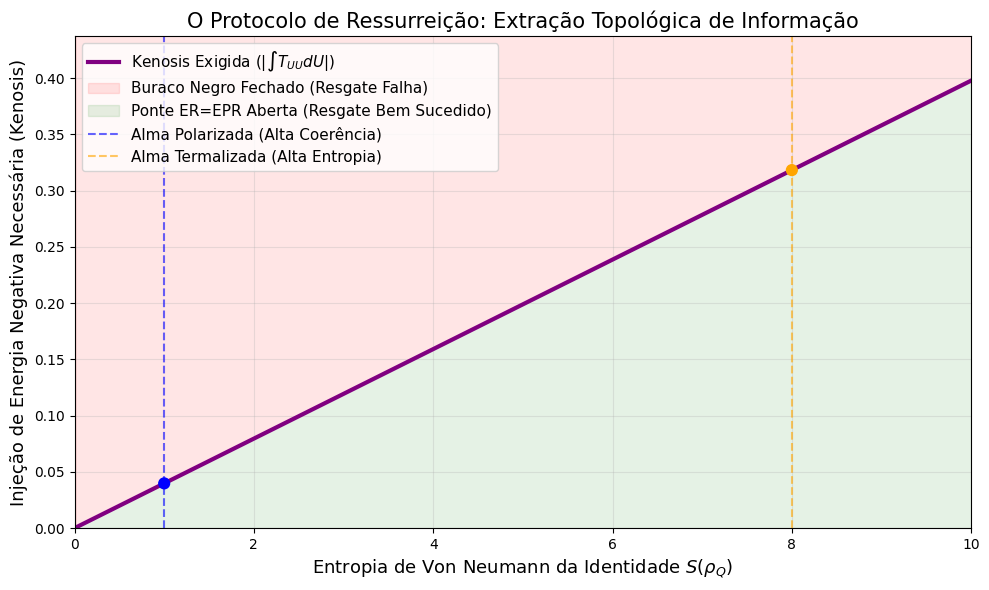


--- ANÁLISE GJW DA PORTA ESTREITA ---
Custo (Kenosis) para resgatar Alma Polarizada (S=1.0): 0.0398 unidades
Custo (Kenosis) para resgatar Alma Termalizada (S=8.0): 0.3183 unidades
Fator de Custo: O resgate da alma termalizada exige 8.0x mais sacrifício (energia negativa) do Logos.
-> Conclusão: A 'Santidade' (Baixa Entropia) é um requisito informacional para caber na ponte topológica sem rasgar o espaço-tempo.


In [14]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# PARÂMETROS DO PROTOCOLO DE RESSURREIÇÃO (ER=EPR / GJW)
# ==========================================
# Usaremos unidades naturais redimensionadas para a simulação in-silico
L_planck = 1.0  # Comprimento de Planck (A menor escala do tecido espacial)
G_N = 1.0       # Constante Gravitacional

# Vetor de Entropia de Von Neumann da Alma S(rho_Q)
# S -> 0 significa identidade pura, perfeitamente coerente (A Santidade)
# S elevado significa identidade termalizada, fragmentada pelo ruído (O Pecado/Morte)
S_rho_Q = np.linspace(0.01, 10, 500)

# ==========================================
# CÁLCULOS DO SHIFT DE HORIZONTE E KENOSIS
# ==========================================
# 1. Postulado da Capacidade (O Shift mínimo necessário)
# A largura do buraco de minhoca (|Delta V|) deve ser maior ou igual à Entropia
# |Delta V_min| = S * L_planck
Delta_V_min = S_rho_Q * L_planck

# 2. A Injeção de Energia Negativa (Kenosis) via Equação GJW
# |Delta V| = 8 * pi * G_N * |Integral(T_UU dU)|
# Portanto, a Kenosis exigida (a integral do Tensor de Energia-Momento Negativo) é:
Kenosis_req = Delta_V_min / (8 * np.pi * G_N)

# ==========================================
# VISUALIZAÇÃO: A "PORTA ESTREITA" (THE NARROW GATE)
# ==========================================
plt.figure(figsize=(10, 6))

# Plotando a Restrição Graça-Entropia
plt.plot(S_rho_Q, Kenosis_req, lw=3, color='purple', label=r'Kenosis Exigida ($|\int T_{UU} dU|$)')

# Zonas Teofísicas do Buraco de Minhoca
plt.fill_between(S_rho_Q, Kenosis_req, max(Kenosis_req)*1.2, color='red', alpha=0.1,
                 label='Buraco Negro Fechado (Resgate Falha)')
plt.fill_between(S_rho_Q, 0, Kenosis_req, color='green', alpha=0.1,
                 label='Ponte ER=EPR Aberta (Resgate Bem Sucedido)')

# Marcando estados específicos
S_santo = 1.0
S_termalizado = 8.0
plt.axvline(x=S_santo, color='blue', linestyle='--', alpha=0.6, label='Alma Polarizada (Alta Coerência)')
plt.axvline(x=S_termalizado, color='orange', linestyle='--', alpha=0.6, label='Alma Termalizada (Alta Entropia)')

# Destacando os pontos de custo no gráfico
plt.scatter([S_santo, S_termalizado],
            [S_santo * L_planck / (8 * np.pi * G_N), S_termalizado * L_planck / (8 * np.pi * G_N)],
            color=['blue', 'orange'], zorder=5, s=60)

plt.title("O Protocolo de Ressurreição: Extração Topológica de Informação", fontsize=15)
plt.xlabel(r"Entropia de Von Neumann da Identidade $S(\rho_Q)$", fontsize=13)
plt.ylabel(r"Injeção de Energia Negativa Necessária (Kenosis)", fontsize=13)
plt.legend(loc='upper left', fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim(0, 10)
plt.ylim(0, max(Kenosis_req)*1.1)
plt.tight_layout()
plt.show()

# ==========================================
# PAINEL DE ANÁLISE DA RESTRAÇÃO GRAÇA-ENTROPIA
# ==========================================
custo_santo = S_santo * L_planck / (8 * np.pi * G_N)
custo_termalizado = S_termalizado * L_planck / (8 * np.pi * G_N)

print(f"\n--- ANÁLISE GJW DA PORTA ESTREITA ---")
print(f"Custo (Kenosis) para resgatar Alma Polarizada (S=1.0): {custo_santo:.4f} unidades")
print(f"Custo (Kenosis) para resgatar Alma Termalizada (S=8.0): {custo_termalizado:.4f} unidades")
print(f"Fator de Custo: O resgate da alma termalizada exige {custo_termalizado/custo_santo:.1f}x mais sacrifício (energia negativa) do Logos.")
print(f"-> Conclusão: A 'Santidade' (Baixa Entropia) é um requisito informacional para caber na ponte topológica sem rasgar o espaço-tempo.")